# Sensor Metadata Analysis for the CUON Dataset

This notebook provides a complete analysis of the sensor identification methods for a specific station.
In particular, three different metadata sources are considered:

- WMO codes: the WMO codes are extracted from table at page A-398 of https://library.wmo.int/doc_num.php?explnum_id=10235 

- Schroeder's codes as can be found in XXX

- IGRA2 metadata that can be downloaded from https://www.ncei.noaa.gov/pub/data/igra/history/


WMO codes are available in the 

In [1]:
import os,sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial

import h5py as h5

import plotly.graph_objects as go
import plotly.express as px

from multiprocessing import Pool
from functools import partial

import urllib.request
pd.options.mode.chained_assignment = None 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


# Directory with the merged files 
merged = '/scratch/das/federico/MERGED_25FEB2022'

#files_n = ['Lindenberg' , 'Payerne', 'Alaska']
#files = ['0-20001-0-10393_CEUAS_merged_v1.nc' , '0-20000-0-06610_CEUAS_merged_v1.nc' , '0-20000-0-70219_CEUAS_merged_v1.nc']


station = '0-20001-0-11035'
station_name = 'Vienna'



## Reading the sensor_configuration table
This table contains is created by union of the Schoreder's and WMO's metadata. This table is confomr to the Common Data Model standards, and included in the CUON dataset files.

In [2]:
# sensor configuration
sensor_conf = pd.read_csv(os.getcwd()+'/data/sensor_configuration_all.csv', sep='\t',  index_col=0)

# add a converted column (to strings)
sensor_id_s = []
for s in sensor_conf.sensor_id.values:
    try:
        s = eval(s).decode('utf-8').replace(' ','')
    except:
        pass
    s = str(s)
    sensor_id_s.append(s)

sensor_conf['sensor_id'] = sensor_id_s

## IGRA2 Metadata
Reading the file from https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata.txt

See https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata-readme.txt for explanations.

The IGRA metadata consist of three principal types of radiosonde station
history information.

1. The primary source is Gaffen (1996):  Records from this source are 
   identified by an update date of 99/1996.

2. Updates to records for GUAN and RATPAC stations (Free et al. 2005) for 
   the period since Gaffen (1996):  Most of these records are identified 
   by a source attribution of Hammer (personal communication) and are 
   based on information received since 2004 through communication between 
   the NCDC GCOS Lead Center and GCOS focal points at Hydrological and 
   Meteorological Service Centers (HMSCs) in WMO member countries. 
   Additional sources of updated information include Joyce (personal 
   communication) and NOAA/NWS.

3. Events supplied by Steve Schroeder of Texas A&M University: 
   Identified by a source attribution of Schroeder (2007), these events 
   cover stations in the Russian Federation, India, Japan, China 
   (including Hong Kong and Taiwan), and Antarctic stations operated by 
   those countries.



In [3]:
if not os.path.isdir('data/igra2-metadata.txt'):
    url = 'https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata.txt'
    urllib.request.urlretrieve(url, 'data/igra2-metadata.txt')

    
names = ['IGRAID', 'WMOID', "NAME", "NAMFLAG" , "LATITUDE", "LATFLAG" , "LONGITUDE", "LONFLAG", "ELEVATION", "ELVFLAG", "YEAR",
           "MONTH", "DAY", "HOUR","DATEIND","EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG","REFERENCE","COMMENT","UPDCOM","UPDATE"] 

colspecs = [(0,11),(12,17),(18,48),(49,50),(50,60),(61,62),(63,72),(73,74),(75,81),(82,83),(84,88),
           (89,91),(92,94),(95,97),(98,99),(100,119),(120,122),(123,162),(163,164),(165,167),(168,207),(208,209),(210,234),(235,314),(315,346),(347,354)]



df = pd.read_fwf('data/igra2-metadata.txt', 
                colspecs=colspecs, names=names,
                )

def get_igra_metadata(station):
    """ Convert the Igra2 Metadata from plain txt into a dataframe,
    for the select station WMO id """
    
    """
    IGRAID         1- 11   Character
    WMOID         13- 17   Integer
    NAME          19- 48   Character
    NAMFLAG       50- 50   Character
    LATITUDE      52- 60   Real
    LATFLAG       62- 62   Character
    LONGITUDE     64- 72   Real
    LONFLAG       74- 74   Character
    ELEVATION     76- 81   Real
    ELVFLAG       83- 83   Character
    YEAR          85- 88   Integer
    MONTH         90- 91   Integer
    DAY           93- 94   Integer
    HOUR          96- 97   Integer
    DATEIND       99- 99   Integer
    EVENT        101-119   Character
    ALTIND       121-122   Character
    BEFINFO      124-163   Character
    BEFFLAG      164-164   Character
    LINK         166-167   Character
    AFTINFO      169-208   Character
    AFTFLAG      209-209   Character
    REFERENCE    211-235   Character
    COMMENT      236-315   Character
    UPDCOM       316-346   Character
    UPDDATE      348-354   Character
    """

    # Using read_fwf with fixed column widths 
    names = ['IGRAID', 'WMOID', "NAME", "NAMFLAG" , "LATITUDE", "LATFLAG" , "LONGITUDE", "LONFLAG", "ELEVATION", "ELVFLAG", "YEAR",
           "MONTH", "DAY", "HOUR","DATEIND","EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG","REFERENCE","COMMENT","UPDCOM","UPDATE"] 

    colspecs = [(0,11),(12,17),(18,48),(49,50),(50,60),(61,62),(63,72),(73,74),(75,81),(82,83),(84,88),
           (89,91),(92,94),(95,97),(98,99),(100,119),(120,122),(123,162),(163,164),(165,167),(168,207),(208,209),(210,234),(235,314),(315,346),(347,354)]

    df = pd.read_fwf('data/igra2-metadata.txt', 
                colspecs=colspecs, names=names  )

    df = df.astype(str)
    wmos = [i if len(i) == 5 else '0'+i for i in df.WMOID]
 
    df['WMOID'] = wmos
    wmoid = station.split('-')[-1]
    #print(wmoid)
    stat = df.loc[df.WMOID == wmoid]
    #print(stat)
    
    # Extracting and converting dates 
    month = [i if len(i) == 2 else '0'+i for i in stat.MONTH]
    month = [m if int(m) <=12 else '01' for m in month]
    stat["MONTH"] = month
    stat["DATE"] = stat["YEAR"].astype(str) + stat["MONTH"].astype(str)
    stat["DATE"] = pd.to_datetime(stat['DATE'] , format='%Y%m' )

    
    update = stat[[ "EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG" ]].agg(' , '.join, axis=1)
    
    u = [ ','.join(  [ v for v in c.split(',') if 'nan' not in v ]) for c in update  ]
    stat['UPDATE'] = u
    stat = stat[ ["DATE", "WMOID", "UPDATE", "REFERENCE", "COMMENT"] ]
    return stat

    
stat_igra2 = get_igra_metadata(station)
#open('facebook.ico', 'wb').write(r.content)

In [4]:
stat_igra2


,DATE,WMOID,UPDATE,REFERENCE,COMMENT
1360,1918-11-01,11035,MISCELLANEOUS,CIA (1993),Independence: 12 November 1918 (from Austro-Hungarian Empire)
1361,1951-11-01,11035,STATION OPENED,Dobesch et al. (1992),STATION MOVED FROM AMERICAN MILITARY AIRPORT to HOHE WARTE SITE
1362,1952-01-01,11035,"USING SONDE MODEL , VIZ AN/AMT-4 UNSPECIFIED",Dobesch et al. (1992),nan
1363,1955-01-01,11035,"CHANGE OBS. TIME , 0300 AND 1500 UTC , to , 0200 AND 1400 UTC",Dobesch et al. (1992),nan
1364,1957-04-01,11035,"CHANGE OBS. TIME , 0200 AND 1400 UTC , to , 0000 AND 1200 UTC",Dobesch et al. (1992),nan
1365,1960-01-01,11035,"USING SONDE MODEL , I1 , VIZ AN/AMT-4B UNSPECIFIED",UK Met. O. (pers. comm.),Derived from WMO (1965)
1366,1960-01-01,11035,"CHANGE SONDE MODEL , VIZ AN/AMT-4 UNSPECIFIED , to , AUSTRIA AN/AMT-4 MODIFIED",Dobesch et al. (1992),"NEW SONDE WAS MODIFIED VERSION ASSEMBLED IN AUSTRIA, NOT IN U.S."
1367,1976-01-01,11035,"USING SONDE MODEL , I1 , VIZ AN/AMT-4 UNSPECIFIED",UK Met. O. (pers. comm.),Derived from SPACKMAN (1977)
1368,1977-02-01,11035,"CHANGE SONDE MODEL , VIZ AN/AMT-4 UNSPECIFIED , to , VIZ ACCU-LOK UNSPECIFIED",Dobesch et al. (1992),nan
1369,1982-01-01,11035,"USING RADIAT. CORR. , R1 , NO RADIATION CORRECTION",UK Met. O. (pers. comm.),Derived from WMO (1982)


In [5]:

def get_sensor_id_comments(sensor_id, sensor_conf):
    """ Extracts the metadata realtive to a given sensor id from the sensor_configuration table """

    s = sensor_id

    # list placeholders
    sensors, description  = [], []

    d = sensor_conf[sensor_conf['sensor_id'] == s ]
    if d.empty:
        s = s.replace('.0', '').replace('.', '')
        if len(s) == 2 and int(s) != 80:
            s = '1' + s
        elif len(s) ==2 and int(s) == 80:
            s = '80'
        d = sensor_conf[sensor_conf['sensor_id'] == s ]

    try:
        com = d.comments.values[0]
    except:
        com = 'NA'        

    try:
        com = eval(com).decode('utf-8')
    except:
        pass

    return com




In [6]:
#get_sensor_id_comments('VDT', sensor_conf)

## Analyze A Specific Station

Here we analyze a specific station.
Reads data from the "/data" directory if data was already extracted in the past. 

Otherwise, the user must have access to the directory of the "merged"  files as indicated above.

In [7]:
def analyze_station(sensor_conf, station):
    
        
    def get_indices(data):
        # find the indices where the sensor was replaced 
        indices = []
        last = ''
        for index, row in data.iterrows():
            sid = row.sensor_id
            #if sid =='nan':
            #    continue
            #print(index)
            if index ==0:
                indices.append(index)
                last = sid
            else:
                if sid == last:
                    continue
                else:
                    #print(sid , ' ' , last )
                    last = sid
                    #print(sid , ' ' , last )
                    indices.append(index)
        return indices
    
    # extracting station primary id 
    
    if not ( os.path.isfile('data/' + station + '_sch.csv') and os.path.isfile('data/' + station + '_wmo.csv')):
        
        print("Retrieving data from merged file")

        file = [f for f in os.listdir(merged) if station in f and 'Sensor' not in f ][0]
        station = file.split('/')[-1].split('_')[0]
        file = merged + '/' + file 
        f = h5.File(file, 'r')
        ts = f['recordtimestamp'][:]
        tsd = pd.to_datetime( ts, unit='s',  origin=pd.Timestamp('1900-01-01') )

        index_minus = np.where(tsd <=  pd.Timestamp('1994-01-01')  )[0][-1]
        #index_plus = np.where(tsd >  pd.Timestamp('1997-01-01')  )[0][0]
        index_plus = np.where(tsd >  pd.Timestamp('2013-01-31')  )[0][0]

        ind_obs = list(f['recordindex'][:]) [index_minus:index_plus]

        #ind_obs_ext = list(f['recordindex'][:]) [index_minus:index_plus_ext]


        i = np.take( f['observations_table']['sensor_id'][:].view('|S4') , ind_obs) 
        ids_s = [s.decode('utf-8') for s in i ]
        dic = { 'date_time': tsd[index_minus:index_plus] , 'sensor_id': ids_s }

        data_sch = pd.DataFrame (dic)
        data_sch['value'] = 1

        f['era5fb'].keys()
        wmoids = np.take( f['era5fb']['sonde_type@conv'][:] , ind_obs)
        wmoids = [str(i) for i in wmoids ]
        dic_wmo = { 'date_time':tsd[index_minus:index_plus] , 'sensor_id':wmoids }
        data_wmo = pd.DataFrame (dic_wmo)
        data_wmo['value'] = 2

        data_wmo.to_csv('data/' + station + '_wmo.csv' , sep = '\t') 
        data_sch.to_csv('data/' + station + '_sch.csv' , sep = '\t') 
            
        f.close()
            
    else:
        print("Loading existing data")
        data_wmo = pd.read_csv( 'data/' + station + '_wmo.csv' , sep = '\t')
        data_wmo['date_time'] = pd.to_datetime(data_wmo['date_time'] )
        data_sch = pd.read_csv('data/' + station + '_sch.csv' , sep = '\t') 
        data_sch['date_time'] = pd.to_datetime(data_sch['date_time'] )

        
    
    # have to remove it for Vienna or it causes troubles with the plot since there is too much data
    data_wmo = data_wmo[data_wmo.sensor_id != 'nan']
    data_wmo = data_wmo.dropna( subset=['sensor_id'] )
    data_wmo = data_wmo.reset_index()
    
    # cleaning also partial df from repeated sensors

    indices_sch = get_indices(data_sch)
    indices_wmo = get_indices(data_wmo)

    

    
    data_sch = data_sch.iloc[indices_sch]
    data_wmo = data_wmo.iloc[indices_wmo] 
    
    # have to remove it for Vienna or it causes troubles with the plot since there is too much data
    data_wmo = data_wmo[data_wmo.sensor_id != 'nan']
    data_df = pd.concat( [data_sch, data_wmo] )

    #unique_ids = np.unique(data['sensor_id'])
    comments = [ str(get_sensor_id_comments(str(i).replace(' ','').replace('.0',''), sensor_conf)) for i in data_df.sensor_id]

    data_df['comment'] = comments
    sid_clean = [str(i).replace('.0','')  for i in data_df.sensor_id]
    data_df['sensor_id'] = sid_clean    



    
    
    return data_sch, data_wmo, data_df


In [8]:

# Extract all sensor data
data_sch, data_wmo, data_df = analyze_station(sensor_conf, station)

# Extract only unique entries
# Extract a small table with unqiue sensors and description 
sensors,ind = np.unique( data_df.sensor_id, return_index= True)
#ind
df_sensor = data_df.iloc[list(ind)] [['sensor_id','comment']]
#df_sensor



Loading existing data


In [9]:
len(data_wmo)


860

## Data Summary 

### Schroeder's and WMO's summary table

In [10]:
data_df[:50]

,Unnamed: 0,date_time,sensor_id,value,index,comment
0,0,1994-01-01 00:00:00,BAE,1,NaN,"BAE Austria Elin radiosonde model 2404, hypsometer pressure {~ 1992} WMO instr=16^ (W2=23, W3=16) <F=?403,P=H>"
3749,3749,1996-07-26 12:00:00,VA8,1,NaN,VA8 exact type insufficiently documented
5629,5629,1997-11-08 12:00:00,V9t,1,NaN,"V9t Vaisala RS90 DigiCORA I, II, or Marwin country corr, ranging wind 31313=67103^ <F=T403DL,P=Sc,T=Wc,U=2Ah,W=Ta>"
5744,5744,1997-12-07 02:00:00,VA8,1,NaN,VA8 exact type insufficiently documented
5745,5745,1997-12-07 06:00:00,V9t,1,NaN,"V9t Vaisala RS90 DigiCORA I, II, or Marwin country corr, ranging wind 31313=67103^ <F=T403DL,P=Sc,T=Wc,U=2Ah,W=Ta>"
6085,6085,1998-03-02 02:00:00,VA8,1,NaN,VA8 exact type insufficiently documented
6086,6086,1998-03-02 06:00:00,V9t,1,NaN,"V9t Vaisala RS90 DigiCORA I, II, or Marwin country corr, ranging wind 31313=67103^ <F=T403DL,P=Sc,T=Wc,U=2Ah,W=Ta>"
6172,6172,1998-03-23 12:00:00,VA8,1,NaN,VA8 exact type insufficiently documented
6173,6173,1998-03-23 18:00:00,V9t,1,NaN,"V9t Vaisala RS90 DigiCORA I, II, or Marwin country corr, ranging wind 31313=67103^ <F=T403DL,P=Sc,T=Wc,U=2Ah,W=Ta>"
6288,6288,1998-04-21 12:00:00,VA8,1,NaN,VA8 exact type insufficiently documented


### IGRA2 summary table

In [11]:
stat_igra2

,DATE,WMOID,UPDATE,REFERENCE,COMMENT
1360,1918-11-01,11035,MISCELLANEOUS,CIA (1993),Independence: 12 November 1918 (from Austro-Hungarian Empire)
1361,1951-11-01,11035,STATION OPENED,Dobesch et al. (1992),STATION MOVED FROM AMERICAN MILITARY AIRPORT to HOHE WARTE SITE
1362,1952-01-01,11035,"USING SONDE MODEL , VIZ AN/AMT-4 UNSPECIFIED",Dobesch et al. (1992),nan
1363,1955-01-01,11035,"CHANGE OBS. TIME , 0300 AND 1500 UTC , to , 0200 AND 1400 UTC",Dobesch et al. (1992),nan
1364,1957-04-01,11035,"CHANGE OBS. TIME , 0200 AND 1400 UTC , to , 0000 AND 1200 UTC",Dobesch et al. (1992),nan
1365,1960-01-01,11035,"USING SONDE MODEL , I1 , VIZ AN/AMT-4B UNSPECIFIED",UK Met. O. (pers. comm.),Derived from WMO (1965)
1366,1960-01-01,11035,"CHANGE SONDE MODEL , VIZ AN/AMT-4 UNSPECIFIED , to , AUSTRIA AN/AMT-4 MODIFIED",Dobesch et al. (1992),"NEW SONDE WAS MODIFIED VERSION ASSEMBLED IN AUSTRIA, NOT IN U.S."
1367,1976-01-01,11035,"USING SONDE MODEL , I1 , VIZ AN/AMT-4 UNSPECIFIED",UK Met. O. (pers. comm.),Derived from SPACKMAN (1977)
1368,1977-02-01,11035,"CHANGE SONDE MODEL , VIZ AN/AMT-4 UNSPECIFIED , to , VIZ ACCU-LOK UNSPECIFIED",Dobesch et al. (1992),nan
1369,1982-01-01,11035,"USING RADIAT. CORR. , R1 , NO RADIATION CORRECTION",UK Met. O. (pers. comm.),Derived from WMO (1982)


In [12]:
# convert stat_igra2 to data_df format and concatenate 

stat_igra2
stat_igra2 = stat_igra2[["DATE","UPDATE"] ]


stat_igra2.DATE
stat_igra2['value'] = 3
stat_igra2['date_time'] = stat_igra2['DATE']
stat_igra2['comment'] = stat_igra2['UPDATE']

stat_igra2['sensor_id'] = 'IGRA2 METADATA'


data_df = pd.concat([data_df, stat_igra2])

In [13]:
len(data_sch)

1171

In [14]:
data_sch[:100]

,Unnamed: 0,date_time,sensor_id,value
0,0,1994-01-01 00:00:00,BAE,1
3749,3749,1996-07-26 12:00:00,VA8,1
5629,5629,1997-11-08 12:00:00,V9t,1
5744,5744,1997-12-07 02:00:00,VA8,1
5745,5745,1997-12-07 06:00:00,V9t,1
6085,6085,1998-03-02 02:00:00,VA8,1
6086,6086,1998-03-02 06:00:00,V9t,1
6172,6172,1998-03-23 12:00:00,VA8,1
6173,6173,1998-03-23 18:00:00,V9t,1
6288,6288,1998-04-21 12:00:00,VA8,1


## Time series of the sensor changes for the station 

Making a time series with the changes in the sensor id types, or relevant IGRA2 metadata. 

Each dot corresponds to a specific sonde type as indicated by the colors in the legend, both for the WMO and the Schroeder's data.
The complete list with the description of the instruments is provided below.

Green dots and green vertical lines represent IGRA2 metadata relative to the station, which might include also sensor information, but non exclusively.



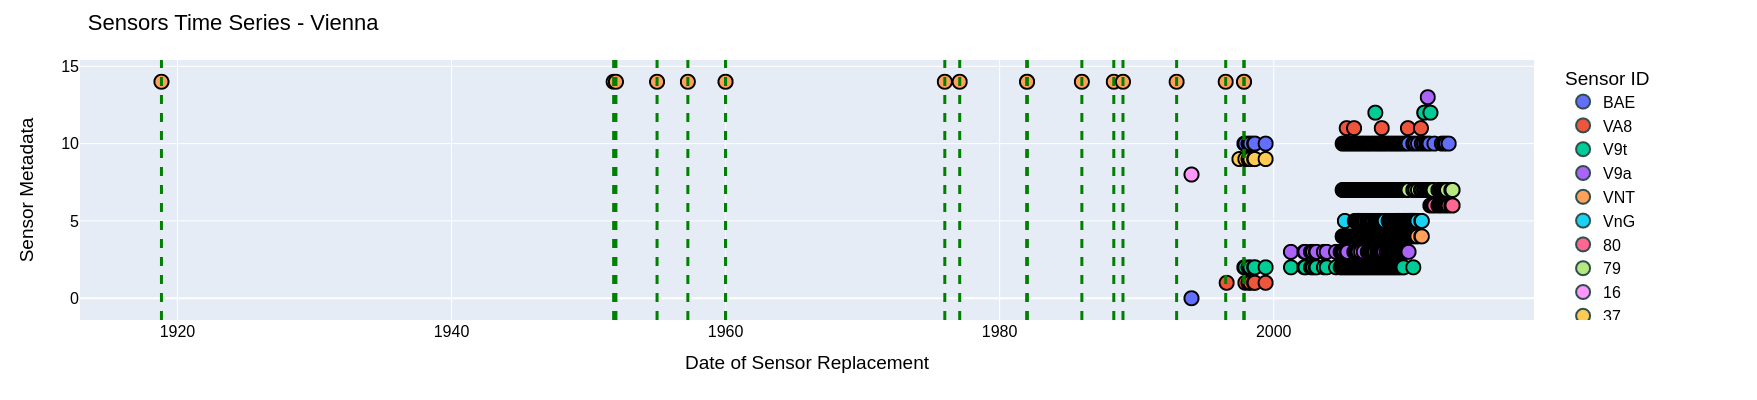

In [17]:
import plotly.express as px


#filter date
#data_df = data_df.loc[data_df.date_time <= pd.Timestamp('1995-01-01')]

data_df['values'] = pd.factorize( data_df.sensor_id)[0]


fig = px.scatter(data_df, x="date_time", y="values", color="sensor_id",
                hover_name="sensor_id", hover_data=["comment"]
                )

fig.update_layout(title='Sensors Time Series - ' + station_name)
#fig.update_yaxes( ticktext= ['Schroeder', 'WMO', 'IGRA2'],
#                  tickvals= [1,2,3])

fig.update_layout(width= 1800, height = 400)

fig.update_layout(
    xaxis_title="Date of Sensor Replacement",
    yaxis_title="Sensor Metadata",
    legend_title="Sensor ID",
    font=dict(
        size=16,
        color="black"
    )
)

fig.update_traces(marker=dict(size=14,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))




for d in stat_igra2.date_time:
    fig.add_vline(x=d, line_width=3, line_dash="dash", line_color="green")



fig.update_layout(hovermode="x unified")

fig.update_layout(
yaxis = dict(
tickfont = dict(size=16)))


fig.show()

## Summary table of the sensor

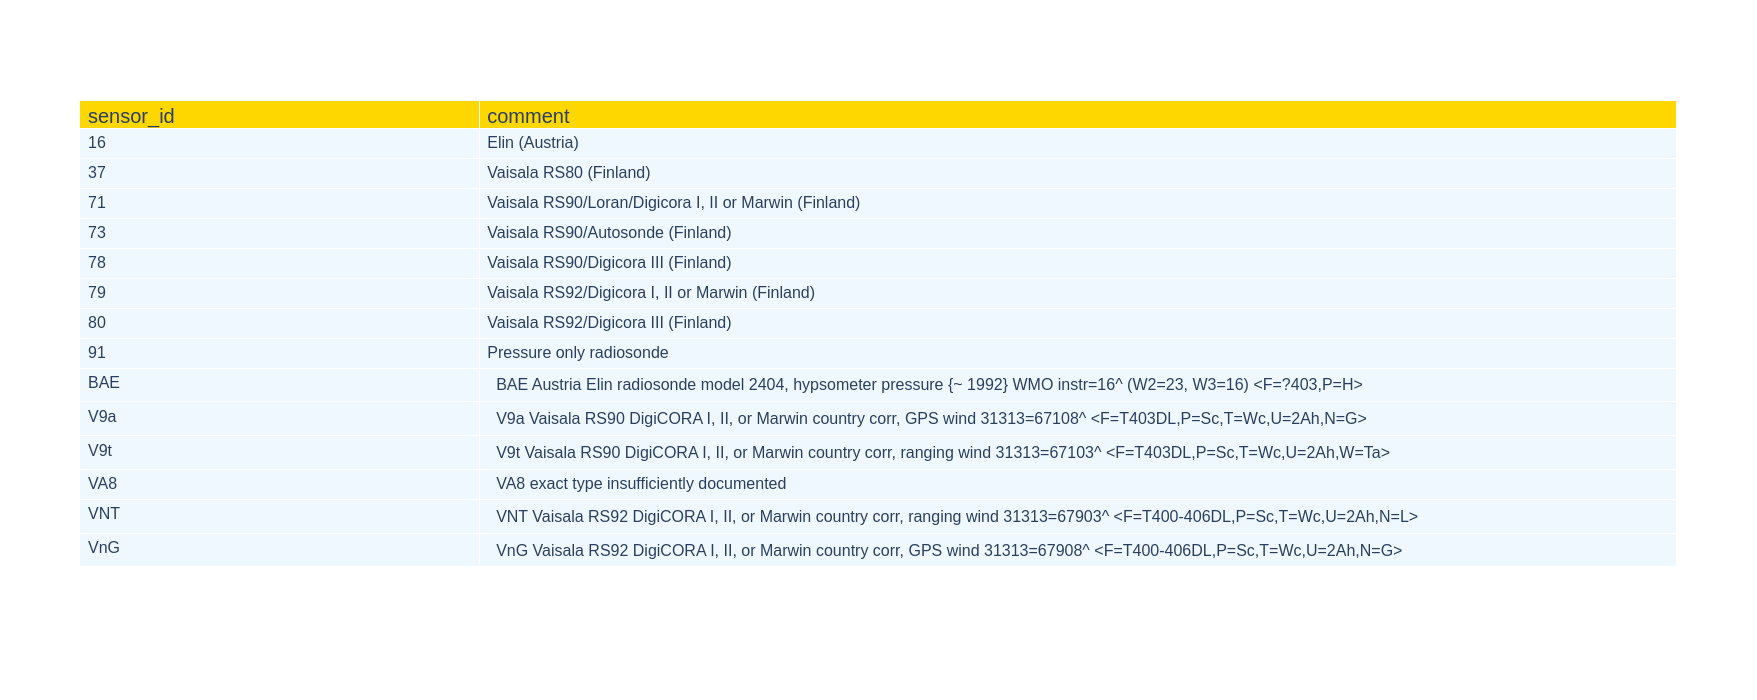

In [18]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['sensor_id','comment']),
                fill_color='gold',
                align='left',
                font_size=20),
    columnwidth = [100,300],
    cells=dict(values=[df_sensor.sensor_id, df_sensor.comment],
               fill_color='aliceblue',
               align='left',
               font_size=16,
               height=30
              )),
])

fig.update_layout(width=1900, height=50*len(df_sensor))

fig.show()

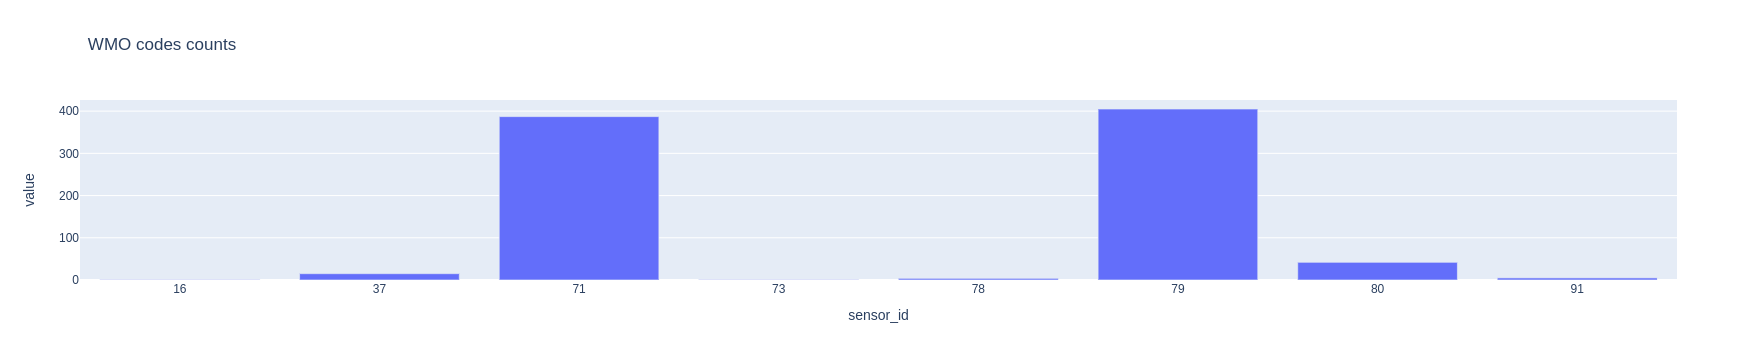

In [19]:
nans_ind = np.where( (data_df.sensor_id != 'nan') & (data_df.value == 2) )[0]
data_df_clean = data_df.iloc[nans_ind]


df = data_df_clean.groupby(["sensor_id"]).count()
fig = px.bar(df, x=df.index, y='value', title = 'WMO codes counts')
fig.show()